In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
import skimage.io as skio
import glob
import tqdm

In [4]:
# Convolutional Neural Network Model Class
class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8,16], img_w=100, img_h=100, num_classes=102):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        # Fully connected layer
        self.fc = nn.Linear(in_features = int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))

        return x

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])


In [6]:
# Hyperparameters Global
NUM_OUT_CH = [8, 16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 64
NUM_EPOCHS = 4
# Learning rate
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = LR)

# Loss Function
# Minimise inacuracies of model
criterion = nn.CrossEntropyLoss()


cpu


,image_path,image_label
0,flowers-102/jpg\image_00001.jpg,76
1,flowers-102/jpg\image_00002.jpg,76
2,flowers-102/jpg\image_00003.jpg,76
3,flowers-102/jpg\image_00004.jpg,76
4,flowers-102/jpg\image_00005.jpg,76
...,...,...
8184,flowers-102/jpg\image_08185.jpg,61
8185,flowers-102/jpg\image_08186.jpg,61
8186,flowers-102/jpg\image_08187.jpg,61
8187,flowers-102/jpg\image_08188.jpg,61


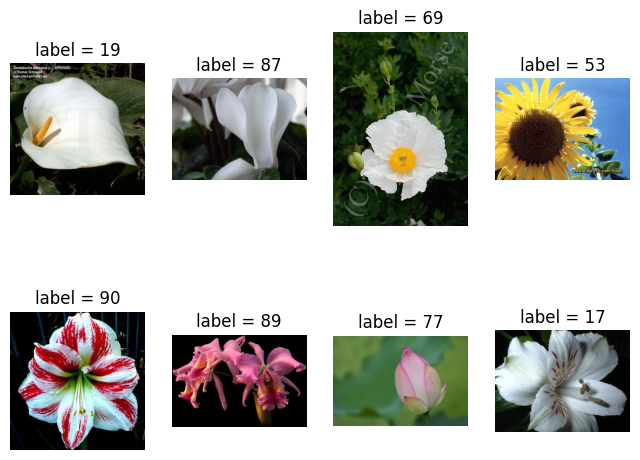

In [7]:
data_path = 'flowers-102/jpg'
label_path = 'flowers-102/imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
# Make the label pythonic as indexing starts at 0
label_arr -= 1
#Images
# sorted(os.listdir(data_path))[0]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1, 8190), 8)
#rows
for i in range(2):
    #cols
    for j in range(4):
        image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
        ax[i, j].imshow(image)
        ax[i, j].axis('off')
        ax[i, j].set_title(f'label = {label_arr[0, image_num[i*4+j]]}')

# data frame: index: 8189; column: 'path', 'label'
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

In [8]:

class MyFlowerDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
    # Understand how many images we have in data set
    def __len__(self):
        return len(self.metadata)
    # Returns an image and a label for a given index
    def __getitem__(self, idx):
        image_path = self.metadata.iloc[idx, 0]
        image = skio.imread(image_path)
        label = torch.tensor(int(self.metadata.iloc[idx, 1]))
        label = F.one_hot(label, num_classes=102)
        label = label.float()
        if self.transform:
            image = self.transform(image)
        return (image, label)
    
# Images must have same dimension by scaling which has downsides of making some images not look like they normall do but upside we don't lose any inforrmation
# Alternative could be to use cropping which has ups and downs too but overall seems that scaling might be best option

flower_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.299, 0.244, 0.255))
])

dataset = MyFlowerDataset(metadata, transform=flower_transform)

# Normally more images for training EXPERIMENT with this
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


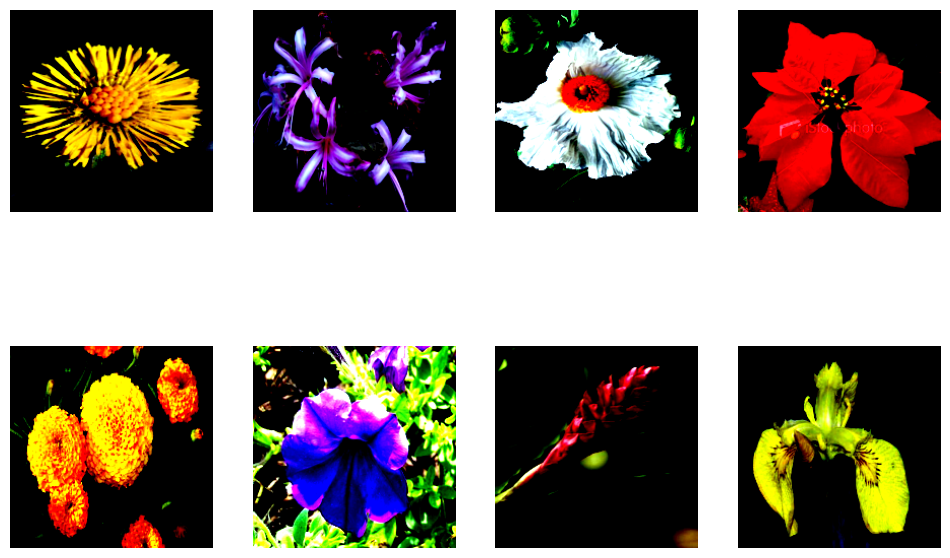

In [9]:
for x, y in train_loader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
    for i in range(2):
        for j in range(4):
            # First 8 images
            ax[i, j].imshow(x[i*4+j].cpu().permute(1, 2, 0))
            ax[i, j].axis("off")
    break
# Images are in "transform" format
    # 1) ToPilImages
    # 2)  Tensore
    # 3) Rescaled
    # 4) Normalised

In [12]:
def check_accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            # sending the data to the device
            x = x.to(device)
            y = y.to(device)

            # preparing the data for the model
            #N/A

            # forward
            y_hat = model(x)

            # calculate ACCURACY
            _, labels = y.max(1)
            _, predictions = y_hat.max(1)
            num_corrects += (predictions == labels).sum()
            num_samples += predictions.size(0)

        print(f'Accuracy: {num_corrects}/{num_samples}: {num_corrects/num_samples * 100:.2f}')
        model.train()
    
# Training loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0
    # Index of mini batch NOT image
    for index, (x, y) in enumerate(train_loader):
        # Send the data to the device
        # Both x, y are pytorch tensors
        x = x.to(device)
        y  = y.to(device)
        
        # Prepare the data
        # N/A

        # Forward  Propogation
        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss
        
        # Backward Propogation
        # Number of images in each mini-batch can effect the efficiency 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch}: loss: {running_loss} ')
    check_accuracy(test_loader, model)

Epoch 0: loss: 5.886824131011963 
Accuracy: 651/1689: 38.54
Epoch 1: loss: 1.5891306400299072 
Accuracy: 694/1689: 41.09
Epoch 2: loss: 0.7186566591262817 
Accuracy: 707/1689: 41.86
Epoch 3: loss: 0.9694135785102844 
Accuracy: 711/1689: 42.10


In [ ]:
# How to improve
# Once training doesn't improve with more epochs, gotta stop training (as you might over fit model)
# Regularisation - get trained even more and not let accuracy plateau


In [14]:
# Progress bar
# Training loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        # Index of mini batch NOT image
        for index, (x, y) in enumerate(tepoch):
            # Send the data to the device
            # Both x, y are pytorch tensors
            x = x.to(device)
            y  = y.to(device)
            
            # Prepare the data
            # N/A

            # Forward  Propogation
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_loss += loss
            
            # Backward Propogation
            # Number of images in each mini-batch can effect the efficiency 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())
        
        print(f'Epoch {epoch}: loss: {running_loss} ')
        check_accuracy(test_loader, model)

100%|██████████| 102/102 [01:47<00:00,  1.05s/batch, loss=0.00299]


Epoch 0: loss: 0.512978732585907 
Accuracy: 671/1689: 39.73


100%|██████████| 102/102 [01:51<00:00,  1.10s/batch, loss=0.00146]


Epoch 1: loss: 1.0448243618011475 
Accuracy: 710/1689: 42.04


100%|██████████| 102/102 [01:54<00:00,  1.12s/batch, loss=0.00185]


Epoch 2: loss: 1.090396761894226 
Accuracy: 688/1689: 40.73


 15%|█▍        | 15/102 [00:15<01:28,  1.02s/batch, loss=0.0021] 